## Setup


In [1]:
import sys
import os
#%cd /content/drive/My Drive/Full stack data school/progetto
!pip install transformers -q

In [3]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np


# preprocessing

In [5]:
df = pd.read_csv('DATA/pre-processed/clean_app_data.csv')
df['Rating'] = df['Rating'].replace(19, np.nan)
orig = df.copy()
orig.set_index(orig['App'], inplace = True)

In [4]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,art_and_design,4.1,159,19.0,10000.0,Free,0.0,Everyone,art;design,2018-01-07,100.0,403.0
1,Coloring book moana,art_and_design,3.9,967,14.0,500000.0,Free,0.0,Everyone,art;design;pretendplay,2018-01-15,200.0,403.0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",art_and_design,4.7,87510,8.7,5000000.0,Free,0.0,Everyone,art;design,2018-08-01,124.0,403.0
3,Sketch - Draw & Paint,art_and_design,4.5,215644,25.0,50000000.0,Free,0.0,Teen,art;design,2018-06-08,10.0,42.0
4,Pixel Draw - Number Art Coloring Book,art_and_design,4.3,967,2.8,100000.0,Free,0.0,Everyone,art;design;creativity,2018-06-20,11.0,44.0


In [5]:
df.isna().sum()

App                  0
Category             0
Rating            1464
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          0
Android Ver          0
dtype: int64

In [6]:
# encoding genres and category

gen = set()
for el in df['Genres'].values:
  el = el.lower()
  gen = gen.union(set(el.split(';')))


# at most, an app has 4 genres
t = []
for el in df.Genres.values:
  t.append(el.split(';'))
l = [len(el) for el in t]
print(max(l))

# to each different genre is associated a prime number
from sympy import sieve
sieve.extend_to_no(61)
gen_dict = dict(zip(list(gen), sieve._list))

def factor(genres, gen_dict):
  diff_gen = genres.split(';')
  encoded = [gen_dict[el] for el in diff_gen]
  for _ in range(4 - len(diff_gen)):
    encoded.append(1) 
  encoded.append(np.prod(encoded))

  return encoded

encoded_gen = np.array([factor(el, gen_dict) for el in df.Genres.values])
df['Feature_1'] = encoded_gen[:, 0]
df['Feature_2'] = encoded_gen[:, 1]
df['Feature_3'] = encoded_gen[:, 2]
df['Feature_4'] = encoded_gen[:, 3]
df['All features'] = encoded_gen[:, 4]

df.drop('Genres', axis = 1, inplace = True)


4


In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ['Category', 'Type', 'Content Rating']:
  df[col] = le.fit_transform(df[col].values)

In [8]:
df['Last Updated'] = df['Last Updated'].apply(lambda x: int(x.split('-')[0]))

# rating imputation knn

In [9]:
from sklearn.impute import KNNImputer

df_knn = df.copy()
df_knn.set_index('App', inplace = True)

imputer = KNNImputer(n_neighbors=2)

df_knn = pd.DataFrame(imputer.fit_transform(df_knn), index = df.App, columns = df.columns[1:]) 
#df_knn.to_csv('DATA/pre-processed/knn_imputation.csv')

# explain knn 

In [26]:
!pip install -q shap

In [27]:
import shap
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
from pylab import rcParams
%matplotlib inline
sns.set(rc={'figure.figsize':(13.0,9.0)})

imputed_knn = pd.read_csv('./clean_data/knn_imputation.csv')
orig_k = orig.copy()
orig_k['Rating'] = imputed_knn['Rating'].values

In [28]:
from sklearn.utils import shuffle
shap.initjs()
data = imputed_knn.drop('App', axis = 1)
data = shuffle(data , random_state = 0)
train = data.iloc[:int(len(data)*0.8)]
test = data.iloc[int(len(data)*0.8):]
test.pop('Rating')


pred_test = default_xgb.predict_proba(test)

explainer = shap.TreeExplainer(default_xgb)
shap_values = explainer.shap_values(test)

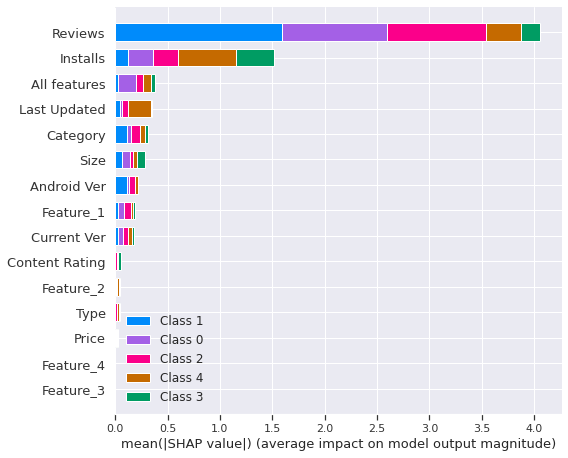

In [29]:
shap.summary_plot(shap_values, test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Original review distribution')

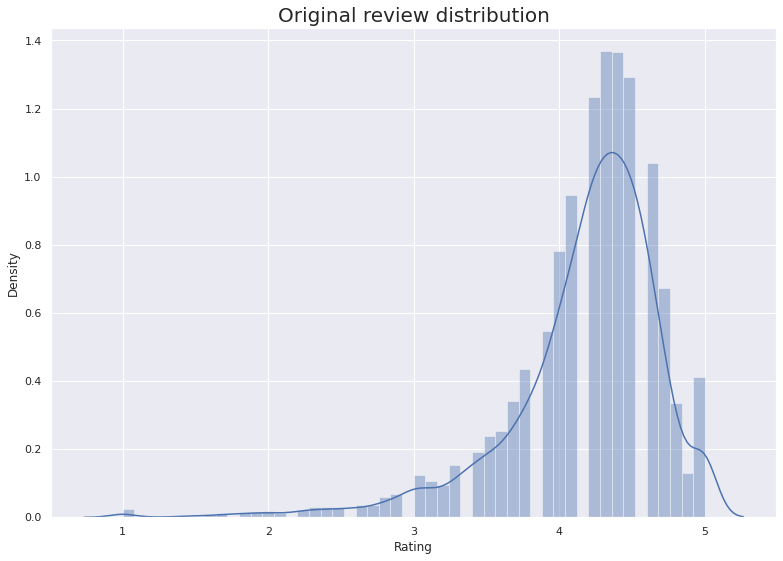

In [30]:
sns.distplot(df.Rating.dropna())
plt.title('Original review distribution',size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Imputed review distribution')

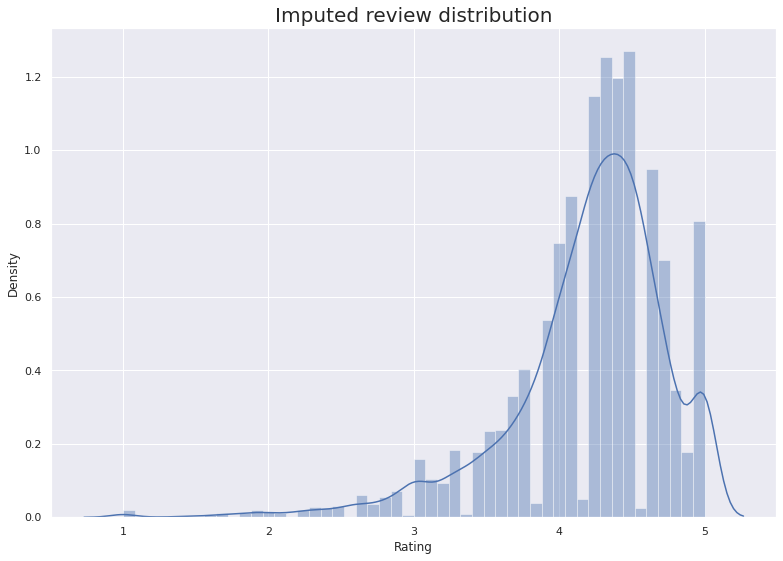

In [31]:
sns.distplot(orig_k.Rating)
plt.title('Imputed review distribution',size = 20)

In [32]:
# from sklearn.neighbors import KernelDensity

# def kl_divergence(p, q):
#     return np.sum(np.where(p != 0, p * np.log(p / q), 0))

# imputed = orig_k.Rating.values.reshape(-1, 1)
# true = df.Rating.dropna().values.reshape(-1, 1)

# kde_k = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(imputed)
# kde_true = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(true)
# # kl_divergence(kde_true, kde_k)
# kl_divergence(kde_k.score_samples(true), kde_k.score_samples(imputed))

Text(0.5, 1.0, 'Count of app in each category')

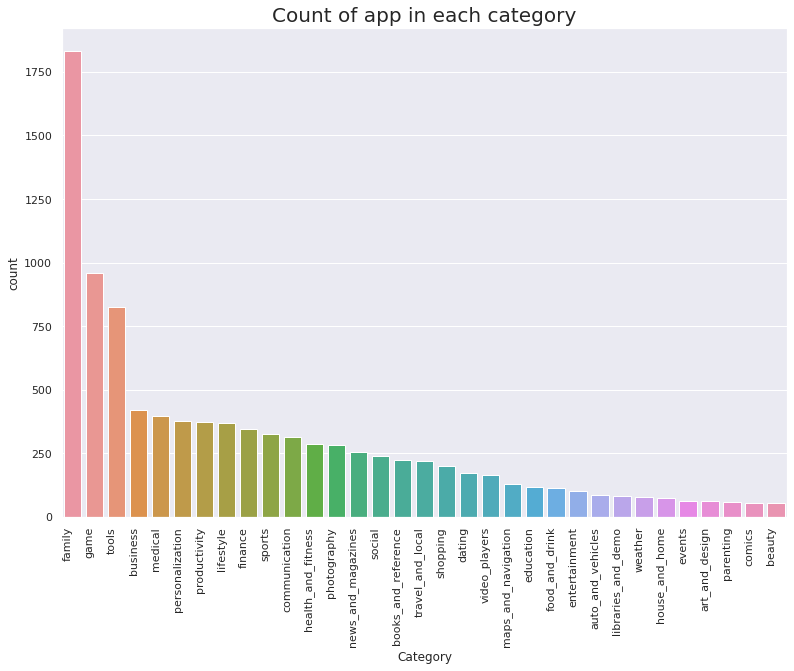

In [33]:
g = sns.countplot(x="Category",data=orig_k, order = orig_k['Category'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Count of app in each category',size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for each category \n mean: 4.2    std: 0.1')

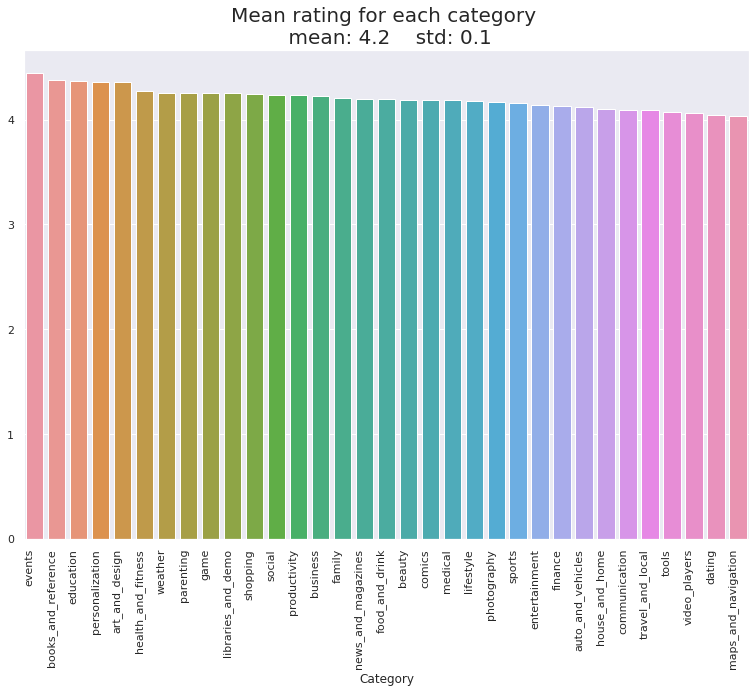

In [34]:
c = orig_k.groupby(by = 'Category')['Rating'].mean().sort_values(ascending = False)
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for each category \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)


In [35]:
media = orig_k.groupby(by = 'Category')['Rating'].mean()
std = orig_k.groupby(by = 'Category')['Rating'].std()
intra_cat = pd.DataFrame(index = media.index)
intra_cat['media'] = media
intra_cat['std'] = std
intra_cat


,media,std
Category,,
art_and_design,4.357812,0.365932
auto_and_vehicles,4.120000,0.548494
beauty,4.184906,0.427491
books_and_reference,4.372973,0.467243
business,4.224286,0.635321
comics,4.182143,0.516758
communication,4.087460,0.592288
dating,4.046784,0.685483
education,4.363025,0.262925


In [36]:
std.sort_values(ascending = False)[:5]

Category
medical               0.710168
lifestyle             0.689880
dating                0.685483
health_and_fitness    0.684948
finance               0.654790
Name: Rating, dtype: float64

In [37]:
media.sort_values(ascending = False)[:5]

Category
events                 4.443750
books_and_reference    4.372973
education              4.363025
personalization        4.360771
art_and_design         4.357812
Name: Rating, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for review count, where reviews < 10k \n mean: 4.15    std: 0.08')

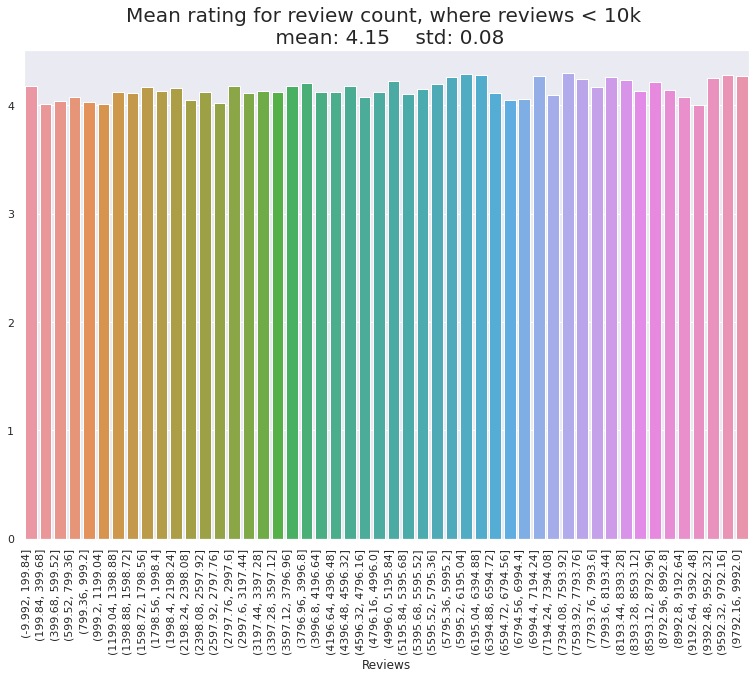

In [38]:
low = 0
up = 10000

cut = orig_k[orig_k['Reviews']< up].copy()
cut.Reviews = pd.cut(cut['Reviews'], 50)
c = cut.groupby(by = 'Reviews')['Rating'].mean()
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for review count, where reviews < 10k \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for review count, where 10k <= reviews < 100k \n mean: 4.26    std: 0.06')

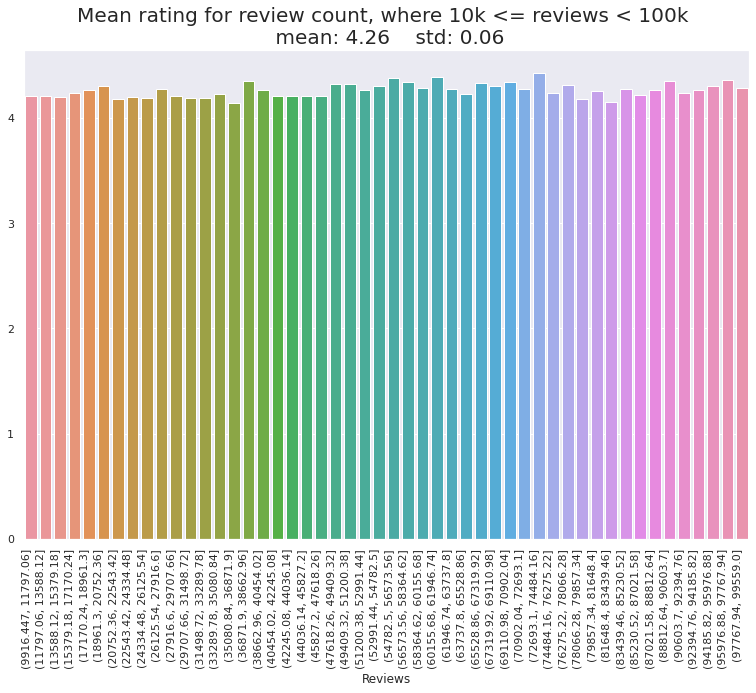

In [39]:
low = 10000
up = 100000

cut = orig_k[ (orig_k['Reviews']>=low) & (orig_k['Reviews']<up) ].copy()
cut.Reviews = pd.cut(cut['Reviews'], 50)
c = cut.groupby(by = 'Reviews')['Rating'].mean()
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for review count, where 10k <= reviews < 100k \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for review count, where 100k <= reviews < 1milione \n mean: 4.38    std: 0.06')

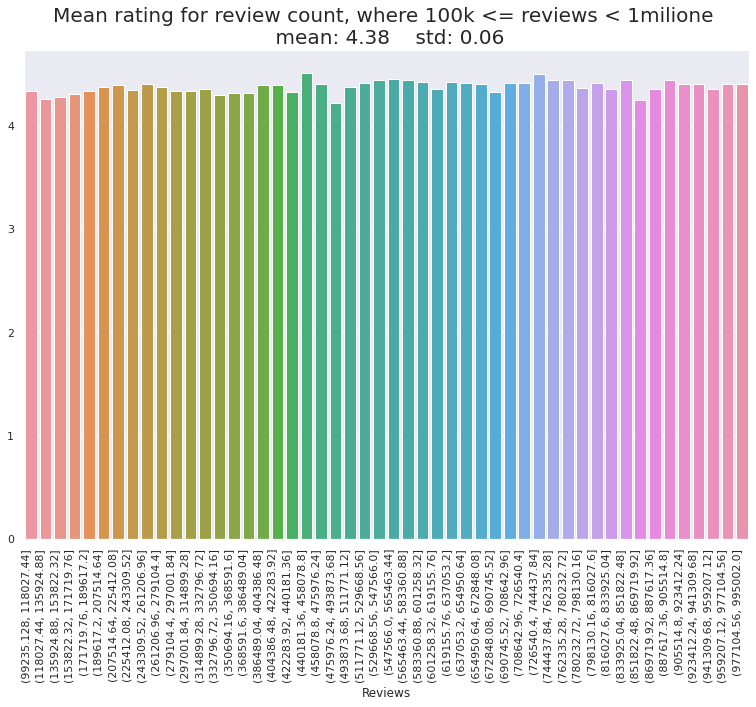

In [40]:
low = 100000
up = 1000000

cut = orig_k[ (orig_k['Reviews']>=low) & (orig_k['Reviews']<up) ].copy()
cut.Reviews = pd.cut(cut['Reviews'], 50)
c = cut.groupby(by = 'Reviews')['Rating'].mean()
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for review count, where 100k <= reviews < 1milione \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for review count, where 1milione <= reviews \n mean: 4.43    std: 0.15')

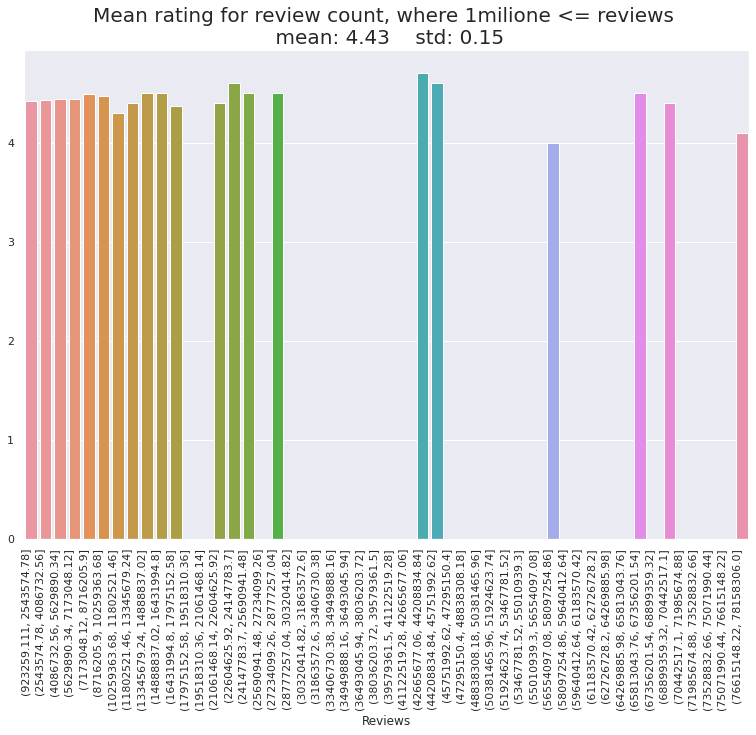

In [41]:
low = 1000000
up = 1000000

cut = orig_k[ (orig_k['Reviews']>=low) ].copy()
cut.Reviews = pd.cut(cut['Reviews'], 50)
c = cut.groupby(by = 'Reviews')['Rating'].mean()
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for review count, where 1milione <= reviews \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)

can't generalize to categories, need to examin low scoring app individually

In [42]:
orig_k[orig_k.Rating <=3]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
App,,,,,,,,,,,,,
Calculator,Calculator,dating,2.60,57,6.200,1000.0,Paid,6.99,Everyone,dating,2017-10-25,1.160000e+02,40.0
FarmersOnly Dating,FarmersOnly Dating,dating,3.00,1146,1.400,100000.0,Free,0.00,Mature 17+,dating,2016-02-25,2.200000e+01,40.0
Just She - Top Lesbian Dating,Just She - Top Lesbian Dating,dating,1.90,953,19.000,100000.0,Free,0.00,Mature 17+,dating,2018-07-18,6.370000e+02,50.0
EliteSingles – Dating for Single Professionals,EliteSingles – Dating for Single Professionals,dating,2.50,5377,19.000,500000.0,Free,0.00,Mature 17+,dating,2018-07-31,4.850000e+02,403.0
Sugar Daddy Dating App,Sugar Daddy Dating App,dating,2.50,277,5.700,100000.0,Free,0.00,Mature 17+,dating,2017-12-04,3.000000e+02,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
FO AIRBUS Nantes,FO AIRBUS Nantes,communication,2.60,0,17.000,100.0,Free,0.00,Everyone,communication,2017-12-14,1.000000e+01,41.0
Fisher-Price® Smart Connect™,Fisher-Price® Smart Connect™,tools,2.70,422,72.000,50000.0,Free,0.00,Everyone,tools,2018-02-23,2.410000e+02,44.0
FP NFC Rewrite,FP NFC Rewrite,tools,2.85,17,0.067,1000.0,Free,0.00,Everyone,tools,2016-01-29,1.100000e+01,40.0


# explain knn low scores

In [43]:
!pip install -q shap

In [44]:
import shap
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
from pylab import rcParams
%matplotlib inline
sns.set(rc={'figure.figsize':(13.0,9.0)})

soglia = 3

imputed_knn = pd.read_csv('./clean_data/knn_imputation.csv')
# orig_k['Rating'] = imputed_knn['Rating'].values
imputed_knn = imputed_knn[imputed_knn['Rating']<soglia]
orig_k = orig_k[orig_k.Rating <soglia]


In [45]:
orig_k.Rating.value_counts()

2.90    50
2.80    43
2.60    39
2.50    23
2.70    23
2.30    20
2.40    19
1.00    16
2.20    15
1.90    14
2.00    12
2.10     9
1.70     8
1.80     8
2.65     6
2.85     6
2.95     4
1.60     4
2.75     4
1.40     3
1.50     3
2.40     1
1.20     1
1.95     1
2.65     1
2.35     1
2.25     1
1.85     1
1.65     1
Name: Rating, dtype: int64

In [46]:
from sklearn.utils import shuffle
shap.initjs()
data = imputed_knn.drop('App', axis = 1)
data = shuffle(data , random_state = 0)
train = data.iloc[:int(len(data)*0.8)]
test = data.iloc[int(len(data)*0.8):]
test.pop('Rating')


pred_test = default_xgb.predict_proba(test)

explainer = shap.TreeExplainer(default_xgb)
shap_values = explainer.shap_values(test)

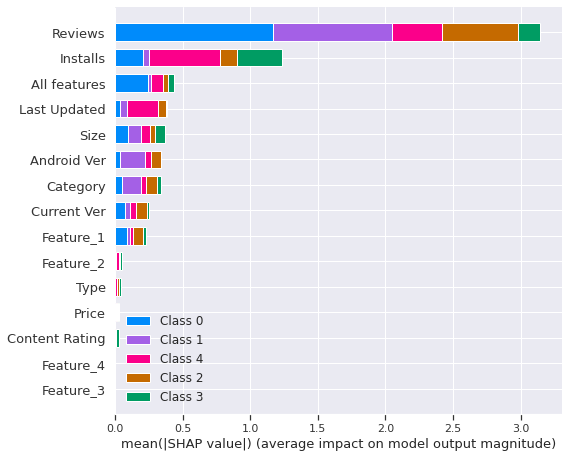

In [47]:
shap.summary_plot(shap_values, test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Imputed review distribution')

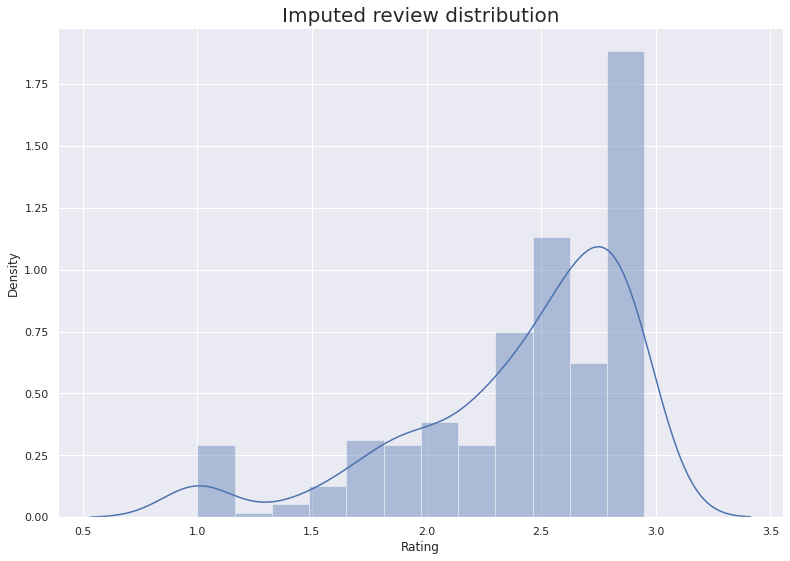

In [48]:
sns.distplot(orig_k.Rating)
plt.title('Imputed review distribution',size = 20)

Text(0.5, 1.0, 'Count of app in each category')

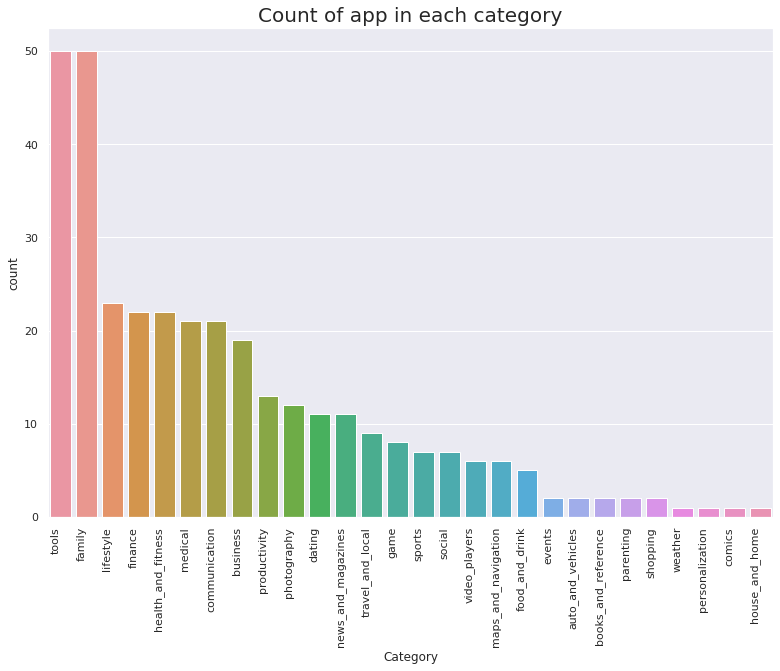

In [49]:
g = sns.countplot(x="Category",data=orig_k, order = orig_k['Category'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Count of app in each category',size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for each category \n mean: 2.46    std: 0.17')

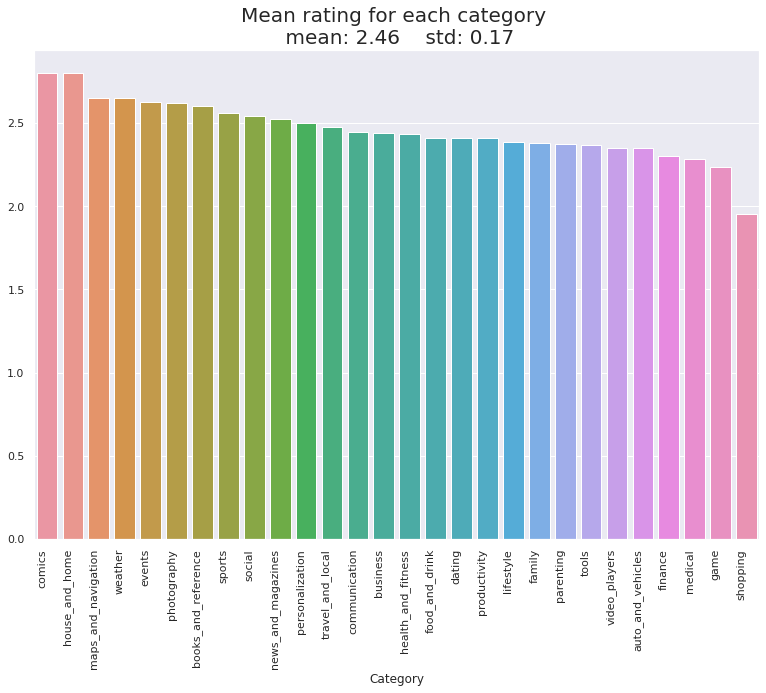

In [50]:
c = orig_k.groupby(by = 'Category')['Rating'].mean().sort_values(ascending = False)
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for each category \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)


In [80]:
cats = orig_k.groupby(by = 'Category')['Rating']
media = orig_k.groupby(by = 'Category')['Rating'].mean()
std = orig_k.groupby(by = 'Category')['Rating'].std()
intra_cat = pd.DataFrame(index = media.index)
intra_cat['media'] = media
intra_cat['std'] = std
intra_cat['Rapporto']=(intra_cat.dropna()['std']/intra_cat.dropna()['media'] * 100).apply(lambda x: round(x, 2))
intra_cat.dropna()

,media,std,Rapporto
Category,,,
auto_and_vehicles,2.350000,0.353553,15.04
books_and_reference,2.600000,0.141421,5.44
business,2.436842,0.470473,19.31
communication,2.447619,0.400149,16.35
dating,2.409091,0.548552,22.77
events,2.625000,0.388909,14.82
family,2.382000,0.546114,22.93
finance,2.302273,0.654377,28.42
food_and_drink,2.410000,0.606630,25.17


In [52]:
std.sort_values(ascending = False)[:5]

Category
game              0.673875
finance           0.654377
medical           0.617927
food_and_drink    0.606630
productivity      0.551455
Name: Rating, dtype: float64

In [53]:
media.sort_values(ascending = False)[:5]

Category
comics                 2.800
house_and_home         2.800
maps_and_navigation    2.650
weather                2.650
events                 2.625
Name: Rating, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for review count, where reviews < 10k \n mean: 2.59    std: 0.25')

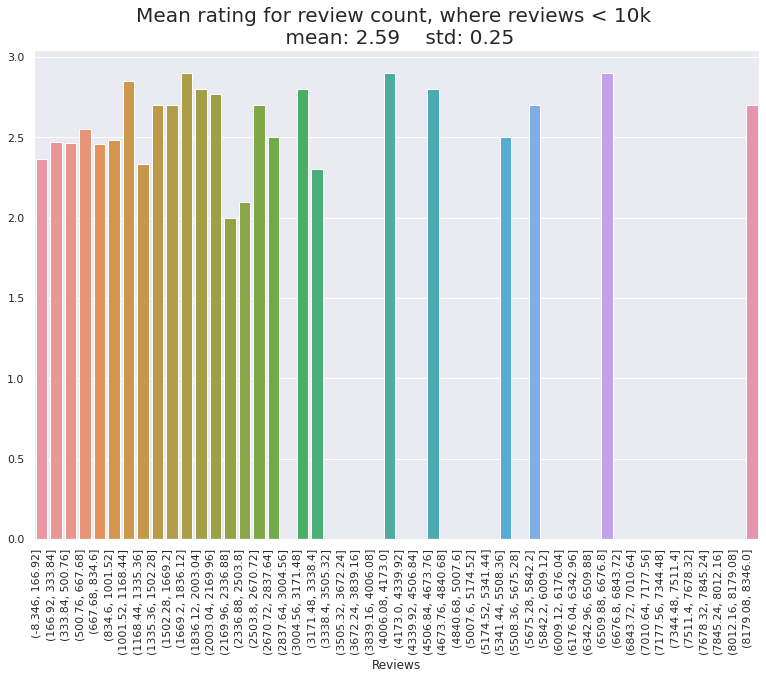

In [59]:
low = 0
up = 10000

cut = orig_k[orig_k['Reviews']< up].copy()
cut.Reviews = pd.cut(cut['Reviews'], 50)
c = cut.groupby(by = 'Reviews')['Rating'].mean()
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for review count, where reviews < 10k \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for review count, where 10k <= reviews < 100k \n mean: 2.7    std: 0.26')

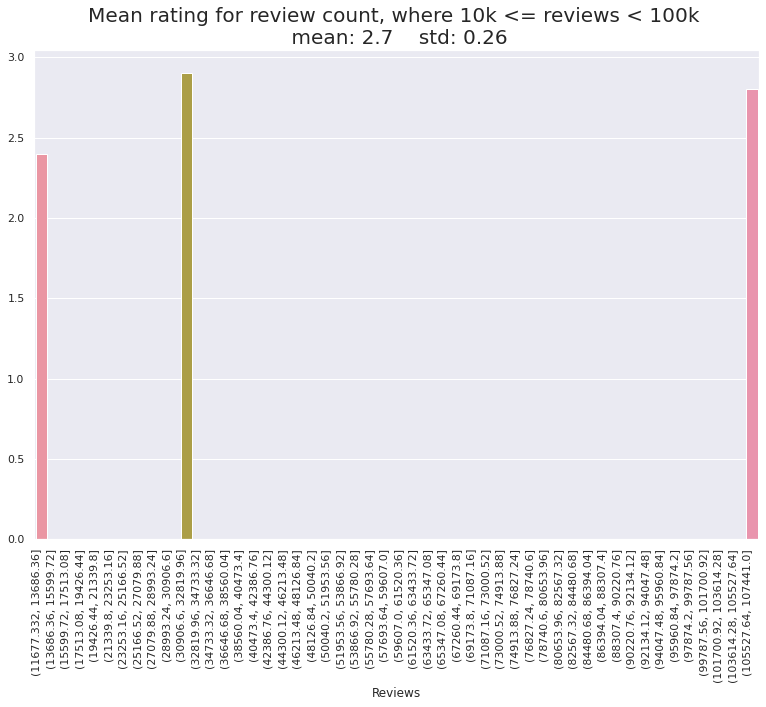

In [62]:
low = 10000
up = 10000000

cut = orig_k[ (orig_k['Reviews']>=low) & (orig_k['Reviews']<up) ].copy()
cut.Reviews = pd.cut(cut['Reviews'], 50)
c = cut.groupby(by = 'Reviews')['Rating'].mean()
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for review count, where 10k <= reviews < 100k \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for review count, where 100k <= reviews < 1milione \n mean: 2.8    std: nan')

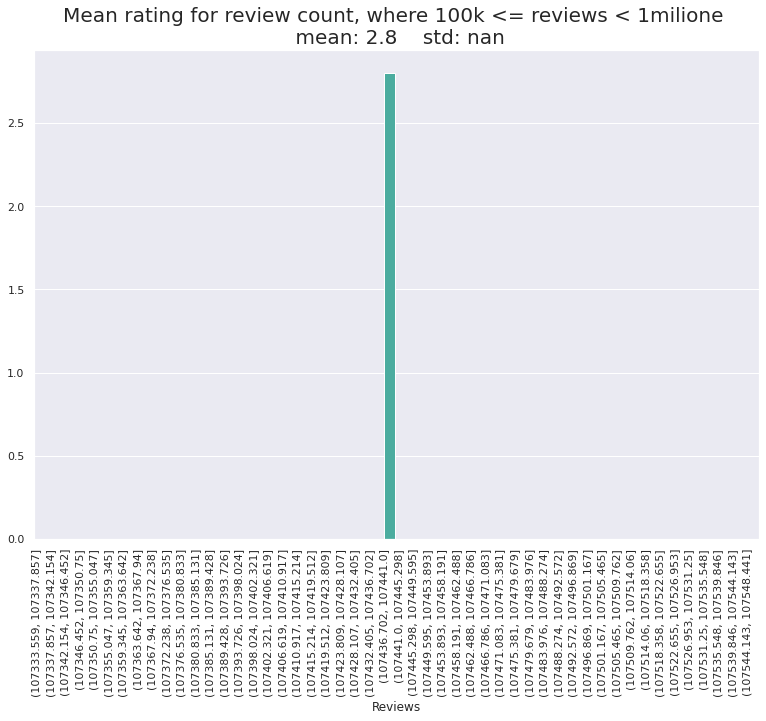

In [56]:
low = 100000
up = 1000000

cut = orig_k[ (orig_k['Reviews']>=low) & (orig_k['Reviews']<up) ].copy()
cut.Reviews = pd.cut(cut['Reviews'], 50)
c = cut.groupby(by = 'Reviews')['Rating'].mean()
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for review count, where 100k <= reviews < 1milione \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)

# Rating imputation xgboost

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

df.index = df['App']
df.drop('App', axis = 1, inplace = True)

missing = df[df['Rating'].isna() == True]
target_mis = missing.pop('Rating')

train = df[df['Rating'].isna() == False]
train['Rating'] = train['Rating'].apply(lambda x: round(x))
target = train.pop('Rating')

x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

default_xgb = XGBClassifier()
default_xgb.fit(x_train, y_train)
pred = default_xgb.predict(x_test)

f1 = f1_score(y_test, pred, labels = [0,1,2,3,4,5], average = 'micro')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
print(f1)

0.7195121951219512


In [17]:
imputed = default_xgb.predict(missing)

missing['Rating'] = imputed

data = pd.concat([df[df['Rating'].isna() == False], missing])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
data.to_csv('./clean_data/xgb_imputation.csv')

# explain xgboost 

In [19]:
import shap
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
from pylab import rcParams
%matplotlib inline
sns.set(rc={'figure.figsize':(13.0,9.0)})

imputed_xgb = pd.read_csv('./clean_data/xgb_imputation.csv')
orig['Rating'] = imputed_xgb['Rating'].values

In [20]:
from sklearn.utils import shuffle
shap.initjs()
data = imputed_xgb.drop('App', axis = 1)
data = shuffle(data , random_state = 0)
train = data.iloc[:int(len(data)*0.8)]
test = data.iloc[int(len(data)*0.8):]
test.pop('Rating')


pred_test = default_xgb.predict_proba(test)

explainer = shap.TreeExplainer(default_xgb)
shap_values = explainer.shap_values(test)


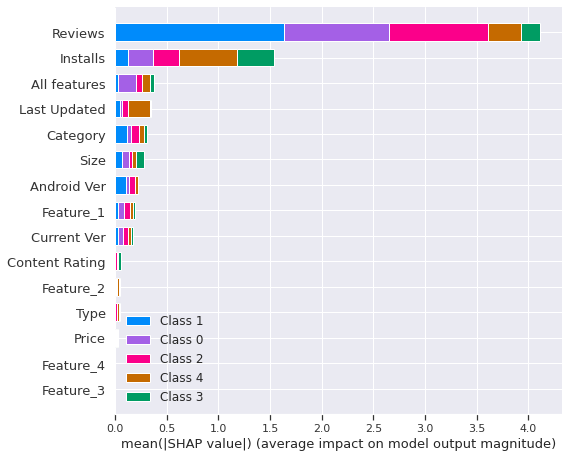

In [21]:
shap.summary_plot(shap_values, test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Imputed review distribution')

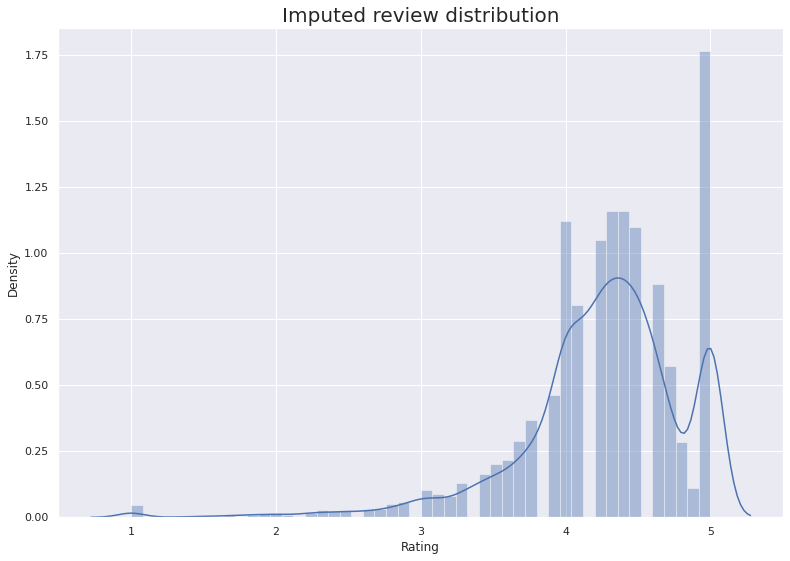

In [22]:
sns.distplot(orig.Rating)
plt.title('Imputed review distribution',size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Original review distribution')

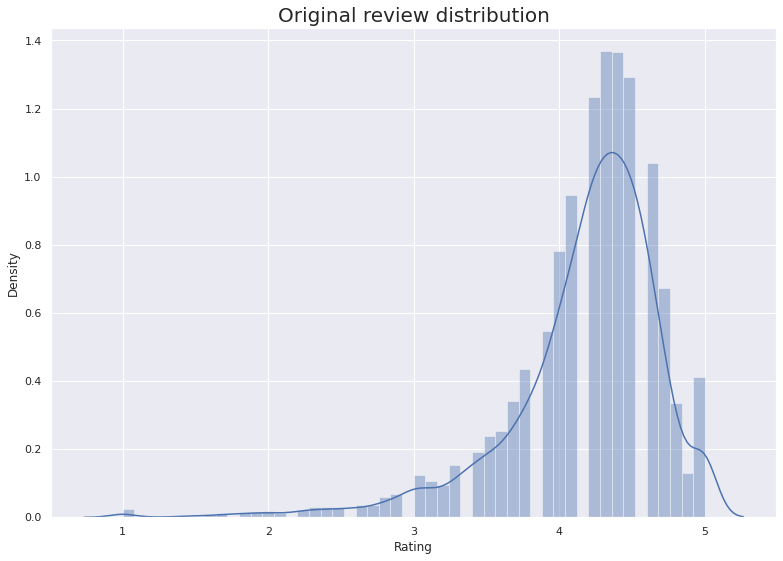

In [23]:
sns.distplot(df.Rating.dropna())
plt.title('Original review distribution',size = 20)

Text(0.5, 1.0, 'Count of app in each category')

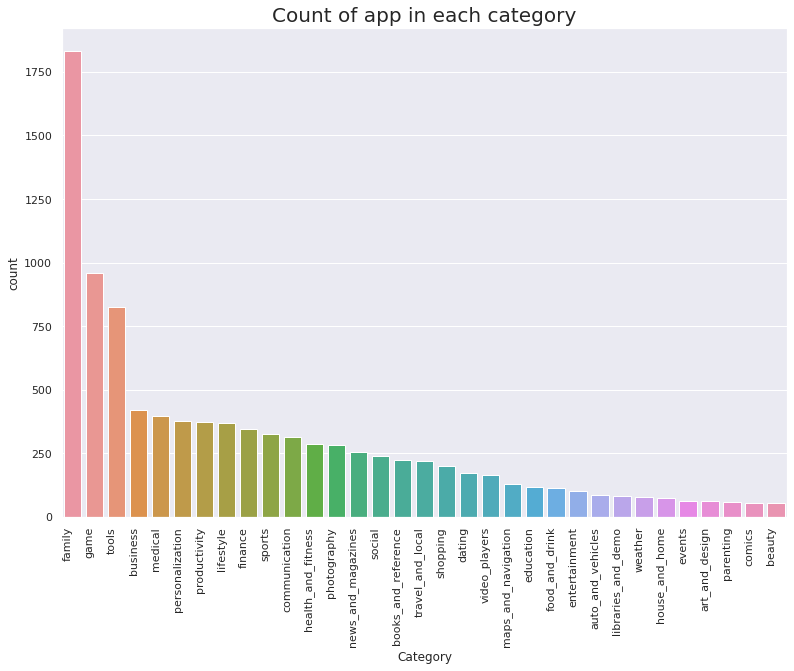

In [24]:
g = sns.countplot(x="Category",data=orig, order = orig['Category'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Count of app in each category',size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Mean rating for each category \n mean: 4.25    std: 0.06')

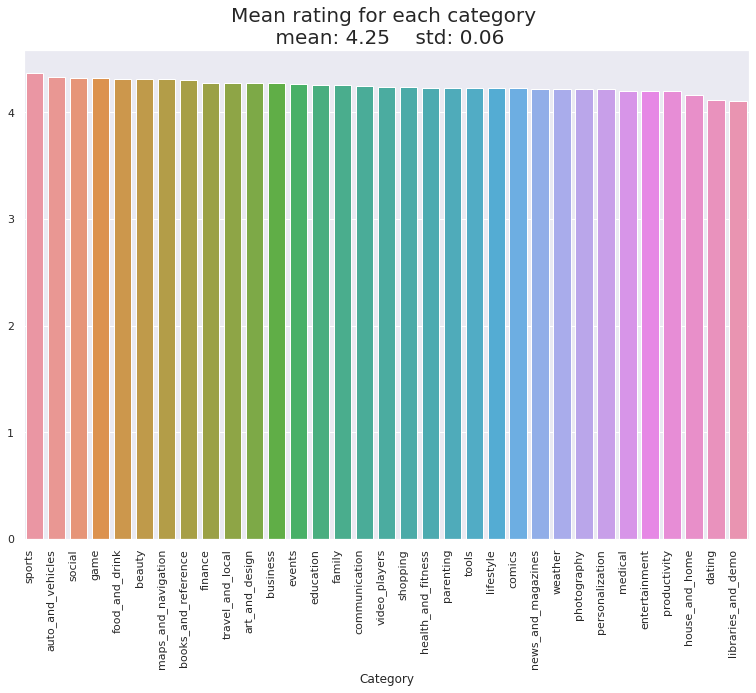

In [25]:
c = orig.groupby(by = 'Category')['Rating'].mean().sort_values(ascending = False)
y = c.values
x = c.index
g = sns.barplot(x, y)
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Mean rating for each category \n' + ' mean: ' + str(round(c.mean(), 2)) + '    std: '+ str(round(c.std(), 2)), size = 20)
